SDK Cookbook

Contents:

Easy stuff: look HERE, HERE, and HERE to do XYX
1. Find product children
2. vessel movements
3. Kplergl product transfers
4. Build custom dashboard (cm heatmap over time) https://medium.com/vis-gl/introducing-kepler-gl-for-jupyter-f72d41659fbf
5. floating storage split by product & grade
6. Custom input parameter jupyter notebook (floating storage minimum duration)
7. speed changes over time
8. optimising inefficiencies
9. Distribution of someting ting

In [131]:
%matplotlib inline

from datetime import datetime
import warnings

from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import vortexasdk as v


warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [66]:
from functools import reduce

def merge(data_frames):
    return reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="outer"
        ),
        data_frames,
    )

### Names lookup



### Manipulate reference data to find product and geography children

Let's write a few methods to help us manipulate the reference data found in the SDK.

In [179]:
geogs = v.Geographies().load_all()

Loading from API: 9000it [00:00, 9482.24it/s]                           


In [181]:
geogs[0]

{'id': '36b0207bd8d835af78dc50d39384e7e0c2953dbdb04ca450d856e47da364c074',
 'name': 'Eritrea',
 'layer': ['country', 'trading_subregion'],
 'leaf': False,
 'parent': [{'name': 'Red Sea',
   'layer': ['shipping_region', 'trading_region'],
   'id': '10d73bcc52e974d25ecf464d97e7d1478c841e1c089ca4eddcdc34e4de0a3e01'},
  {'name': 'Africa',
   'layer': ['region'],
   'id': 'c4a371acd7c3df8bd70e49805e76cb39b1309ccac3d0f4289120079a9ad68bcd'}],
 'exclusion_rule': [{'name': 'Eritrea',
   'layer': ['country', 'trading_subregion'],
   'id': '36b0207bd8d835af78dc50d39384e7e0c2953dbdb04ca450d856e47da364c074'}],
 'ref_type': 'geography',
 'hierarchy': [{'id': '36b0207bd8d835af78dc50d39384e7e0c2953dbdb04ca450d856e47da364c074',
   'layer': 'country'},
  {'id': 'c4a371acd7c3df8bd70e49805e76cb39b1309ccac3d0f4289120079a9ad68bcd',
   'layer': 'region'},
  {'id': '10d73bcc52e974d25ecf464d97e7d1478c841e1c089ca4eddcdc34e4de0a3e01',
   'layer': 'shipping_region'},
  {'id': '10d73bcc52e974d25ecf464d97e7d1478c84

In [186]:
def find_children_ids(parent_id):
    return [g['id'] for g in geogs if parent in [p['id'] for p in g['parent']]]

In [187]:
parent = 'c4a371acd7c3df8bd70e49805e76cb39b1309ccac3d0f4289120079a9ad68bcd'
find_children_ids(parent)

['36b0207bd8d835af78dc50d39384e7e0c2953dbdb04ca450d856e47da364c074',
 '6b695d7631cc0601bbf3282a956432e8a450b25a8145c1cf131386373e97ca8e',
 'd93823ebdbde2e10f127caa62e6a23e2599252cc1582387869fac188c7560246',
 '5fe46e04994d11413f7a0b17bb2e12cb4ce78b5bd2770a9242dc465a50baa18f',
 'e0e72896f2d07d134de6efb2d6541bed7e297e17f010f67f30247abc56d92c6c',
 'b48105958f0107629217f8118dd631860726e40d7e02c2a3f8b29938233f4a71',
 '75e8f462f9dae90e449fc1a7e4e3ca571f83541f5314096f4de1d224c4dbfacc',
 'b4dea4ca32aa84b8d96bfd015459da8d00fed4ba6e72e185c4016cb9915c4405',
 '7cabc7e02461a788af6c61e24d09df8790d9002f6bf614c6c88e5237ccd75011',
 '75d0436e9f47508020863fb5108eb31955a95d754083075d014f3564dfb432b5',
 '57c5119ac46cdc6ffe1c2d6b861b7c975385483c649f0708beb09de81d570543',
 '5078bca8d0b0f7f9d30f3c1883e2b42f6d616761d312331a6ca7dd5776d590a8',
 '03b07ca887edb311bf70d7dc51a802539c73a404a23f3a2b08cf5e7a04128336',
 'fde14d5b0b8f8c943d66e55b81254af86267988a6a44bdd755b75bd89cf01b11',
 '4681639741f445ef193092a92a0d7797

By inspecting the sample product found here, we see that each product record contains a unique `id`, and a list of that product's parent ids.

In [169]:
reference_records = geogs

In [170]:
id_to_name = {r['id']: r['name'] for r in reference_records}

In [171]:
child_to_parent = {r['name']: [parent['name'] for parent in r['parent']] for r in reference_records}

In [173]:
from collections import defaultdict

parent_to_child = defaultdict(set)

for child, parents in child_to_parent.items():
    for parent in parents:
        parent_to_child[parent].add(child)

### Custom Floating Storage trends

topics covered:
floating storage
interactive notebooks
timeseries

Here we use the CargoTimeSeries SDK endpoint and Jupyter Notebook's interactive plotting features to explore global .

Let's see how the total tonnage of Crude in floating storage globally has varied over the last year. The definition of floating storage is a fluid one, does a vessel standing stationary for 7 days count as floating storage, or is 14 days required? The SDK lets us specify the minimum days required for a cargo to be included in floating storage aggregates, we'll take advantage of that parameter here.

First we use the Products endpoint to find the id of Crude/Condensates

Then, we search the CargoTimeSeries endpoint, finding the total global tonnage in floating storage each day over the last 3 years. The minimum-days-required-for-a-stationary-vessel-to-count-as-floating-storage parameter (we'll call this `min_days` from now on), we'll consider `7, 10, 13, ... 31` days, given by python's range function, `range(7, 32, 3)`.

Merging these dataframes allows us to interactively plot each column.

In [116]:
crude_and_condensates = v.Products().search('Crude/Condensates', exact_term_match=True)[0]["id"]

START_DATE = datetime(2017, 9, 31)
END_DATE = datetime(2020, 9, 31)

def convert_days_to_ms(n_days):
    return 1000 * 60 * 60 * 24 * n_days

def fetch_global_crude_floating_storage_timeseries(n_days_storage_minimum):
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = v.CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit='t',
                                     disable_geographic_exclusion_rules=True,
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     timeseries_activity_time_span_min=convert_days_to_ms(n_days_storage_minimum),
                                     filter_time_min=START_DATE,
                                     filter_time_max=END_DATE).to_df(columns=['key', 'value'])
    
    # convert to kt
    df_fs['value'] = df_fs['value'] / 1000
    
    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': 'min{}d kt'.format(n_days_storage_minimum)
                                 })
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)
    
    return df_fs.set_index('date')

In [125]:
dfs = [fetch_global_crude_floating_storage_timeseries(d) for d in range(7, 32, 3)]
df = merge(dfs)

In [134]:
def f(min_days):
    plt.figure(2)
    x = df.index
    y_col = 'min{}d kt'.format(min_days)
    y = df[y_col]
    df[y_col].plot(ylim=(0, df.max().max()))
    
    plt.xlabel('date')
    plt.ylabel('kt');
    plt.title('Crude global floating storage, of minimum duration {} days'.format(min_days))

interactive_plot = interactive(f, min_days=(7, 32, 3))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=19, description='min_days', max=32, min=7, step=3), Output()), _dom_clas…

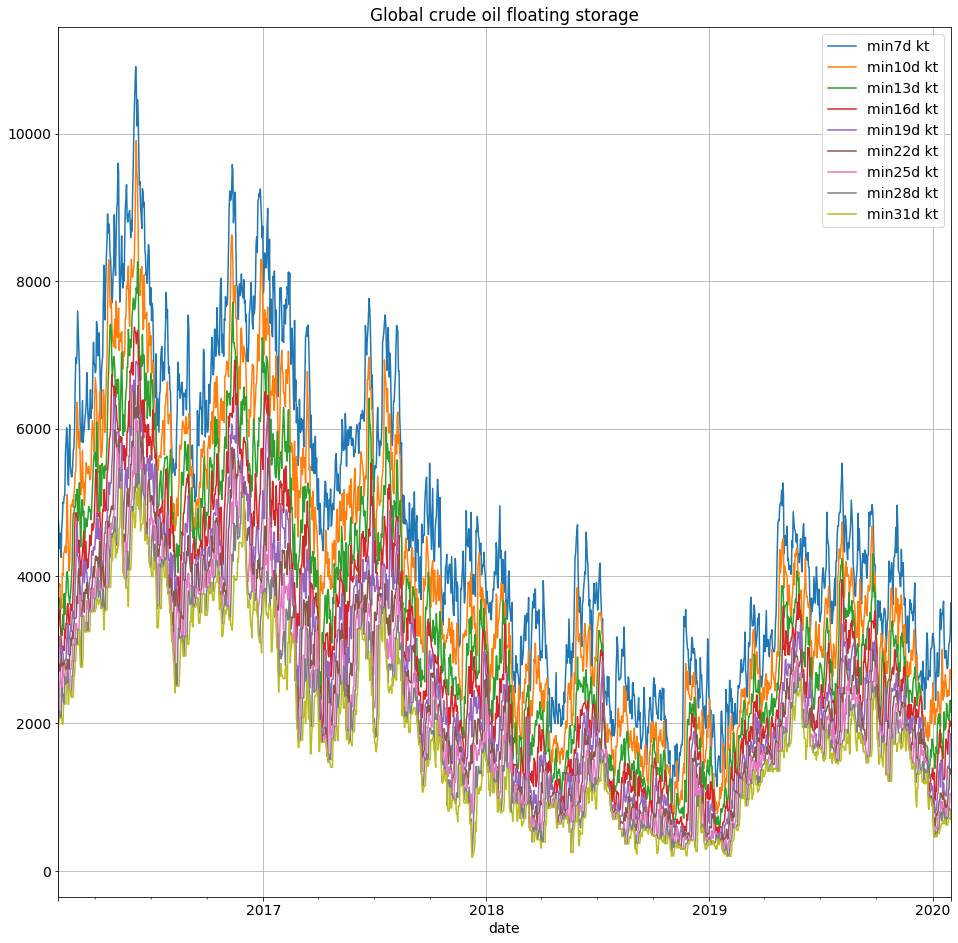

In [135]:
df.plot(title='Global crude oil floating storage', grid=True, figsize=(16, 16));